# Week 8 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic networks. A word or document network is an unsupervized representation of text akin to a clustering or an embedding, but semantic networks can also be defined using semantic or syntactic information derived from methods we have used earlier in the quarter. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify *them*). Rendering words linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, andsophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity.

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats

import pickle #if you want to save layouts
import os

%matplotlib inline

# An Introduction to networks in *networkx*

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph:

In [2]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dictionary.

In [3]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [4]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [5]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [6]:
g.nodes[1]

{}

In [7]:
g.nodes[1]['type'] = 'NN'

In [8]:
g.nodes[1]

{'type': 'NN'}

In [9]:
g.nodes[2]['name'] = 'dog'

In [10]:
g.nodes[2]

{'name': 'dog'}

Still pretty boring...

Lets add a couple of edges. Notice that we use the ids, but not any of the properties:

In [11]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Moreover, there's one additional node, because we asked for an edge to 4.

We can also give the edges properties like weights:

In [12]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize our graph now:

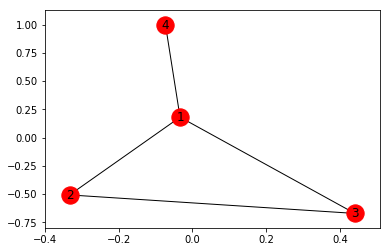

In [13]:
nx.draw_networkx(g)
plt.savefig("test.png")

Very exciting :-).

There are many things to do with the graph once we have created it, some of which we will explore here.

First let's load some data, like the Grimmer Senate press releases corpus:

In [15]:
senReleasesDF = pandas.read_csv('../Codes_Data/data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now).

In [16]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

Let's begin by looking at words that co-occur in the same sentences:

In [17]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

First, build a graph based on word cooccurences in the first 100 press releases.

In [18]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

In [110]:
#MYCODE
g_review = wordCooccurrence(closed_restaurant_reviews['normalized_sents'][:100].sum())

Total number of vertices:

In [22]:
len(g.nodes)

4270

In [94]:
#MYCODE
len(g_review.nodes)

1545

Total number of edges:

In [20]:
len(g.edges)

2082420

In [98]:
#MYCODE
len(g_review.edges)

0

A part of the adjacency matrix of cleaned word by press releases:

In [21]:
nx.to_numpy_matrix(g)[:5, :5]

matrix([[  0.,   0.,   0.,   0.,   0.],
        [  0., 212.,   2.,   0.,   0.],
        [  0.,   2.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   4.]])

We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.

In [ ]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [23]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [24]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [70]:
#MYCODE
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence_review = senVectorizer.fit_transform(closed_restaurant_reviews['text'][:100])

In [25]:
senVects_incidence.shape

(100, 4270)

In [71]:
#MYCODE
senVects_incidence_review.shape

(100, 1545)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [26]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [72]:
#MYCODE
g_2mode_review = nx.Graph()

#define all the nodes
g_2mode_review.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence_review.shape[1])), bipartite = 'word')
g_2mode_review.add_nodes_from(range(senVects_incidence_review.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode_review.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence_review[d, w]}) for d, w in zip(*senVects_incidence_review.nonzero())))

In [27]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 4370
Number of edges: 22325
Average degree:  10.2174


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. 

Let's plot the bipartite network with a quick spring layout:

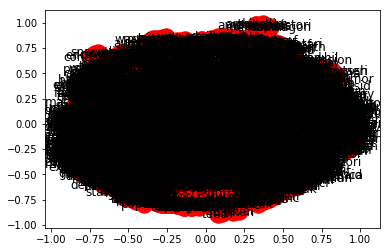

In [28]:
nx.draw_networkx(g_2mode)

With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [29]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [30]:
gDoc = contractNetwork(g_2mode, 'doc')

In [63]:
#MYCODE
def contractNetwork_review(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode_review.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode_review.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [74]:
#MYCODE
gDoc_review = contractNetwork_review(g_2mode_review, 'doc')

Let's first take a look at the document-to-document network:

In [75]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

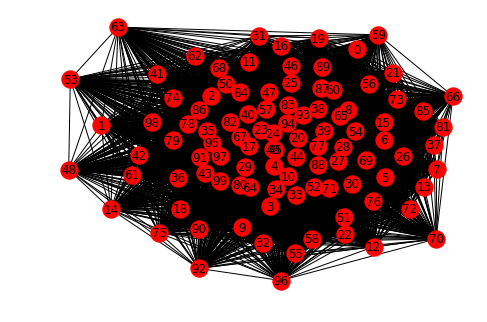

In [32]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

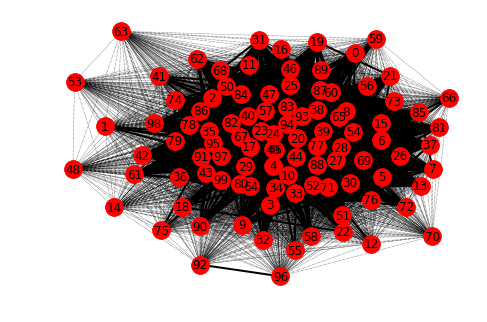

In [33]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [34]:
print(len(senReleasesDF.iloc[63]['text']),"words:","\n",senReleasesDF.iloc[63]['text'].strip().replace('  ', '\n'))

314 words: 
 FOR IMMEDIATE RELEASE

Senator Kennedy issued the following statement this evening following Senator Kerrys apology

John Kerry s statement says it all
I wish the Bush administration brought as much energy and focus to trying to correct their mistakes in Iraq as it did in going after John Kerry


In [35]:
print(len(senReleasesDF.iloc[23]['text']),"words:","\n",senReleasesDF.iloc[23]['text'].strip().replace('  ', '\n'))

20603 words: 
 FOR IMMEDIATE RELEASE
REID

 We re sorry that we re starting a little bit late
but the House has some votes going
and so Leader Pelosi will be here and Congresswoman Solis real soon

 I m reminded of the story I learned as a little boy
When the kid was watching the sheep and he was supposed to yell
Wolf
when the wolf was coming
And he yelled
Wolf
as we know

Wolf
Wolf
and there was never any wolf
And finally when a wolf showed up
no one came

 And no matter how hard we try to be bipartisan here in Washington
with President Bush it s the proverbial cry for wolf

 As I said leaving the chamber last night
whatever he says
it s just the opposite

 And we re here today to talk about health care
But the cry of wolf is once again ringing in my ears because he keeps talking about how he wants to improve health care and we re now five years into this and there s been no improvement

 In fact
I hope the president mentions when he s in Tennessee today that there s almost a million 

Ah...those documents with the **most** words are unsprisingly the most central in this simple document network.

Now let's turn it around and look at the word-to-word network by documents. 

In [36]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 4270
Number of edges: 2080405
Average degree: 974.4286


First, let's reduce the number of words to a manageable size.

In [37]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.9883402510568855

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 1250, then drop all the isolates:

In [38]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 1250])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first
giant = max(nx.connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 496
Average degree:   5.9759


1545

A bit smaller now, Now, let's visualize it: 

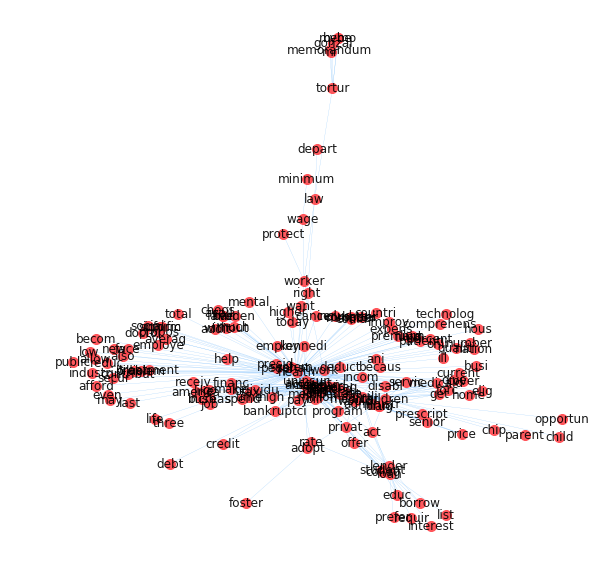

In [39]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score):

In [40]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 496
Average degree:   5.9759


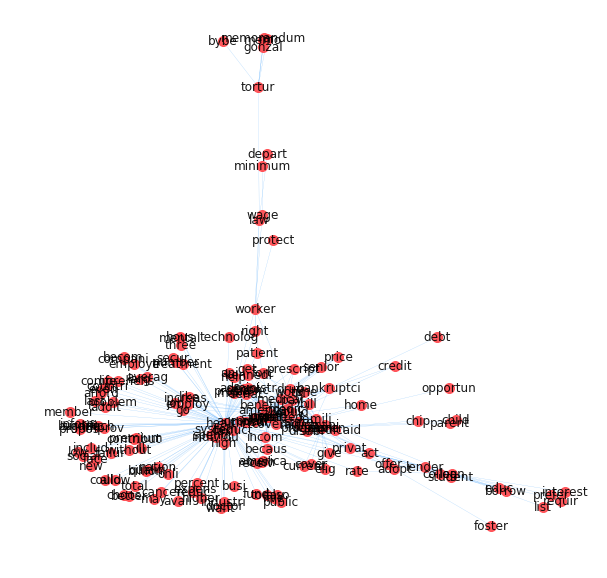

In [41]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally to investigate the structure of words at alternative slices of network density. 

Moreover, we can find cliques, or completely connected sets of nodes. 

In [42]:
nx.clique.number_of_cliques(giant)['presid']

2

In [43]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

health, care, cost, plan, year, insur, save, provid, american, uninsur, account


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'. 

In [44]:
americanNeighbors = giant.neighbors('american')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: SubGraph
Number of nodes: 22
Number of edges: 154
Average degree:  14.0000


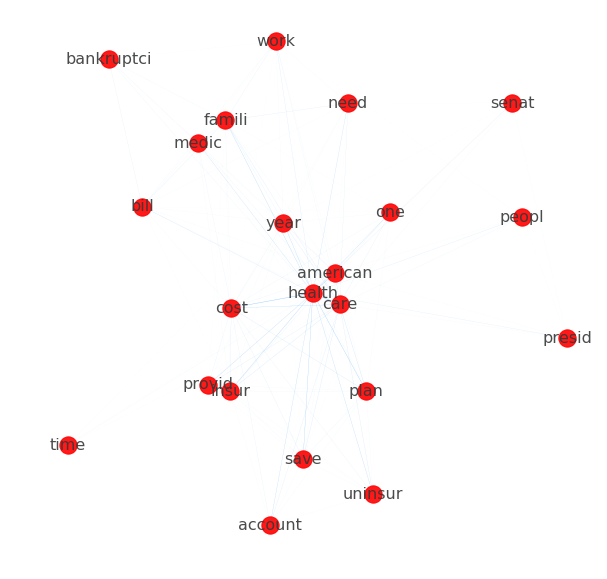

In [45]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [46]:
americanNeighbors = gWord.neighbors('american')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [47]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: SubGraph
Number of nodes: 165
Number of edges: 474
Average degree:   5.7455


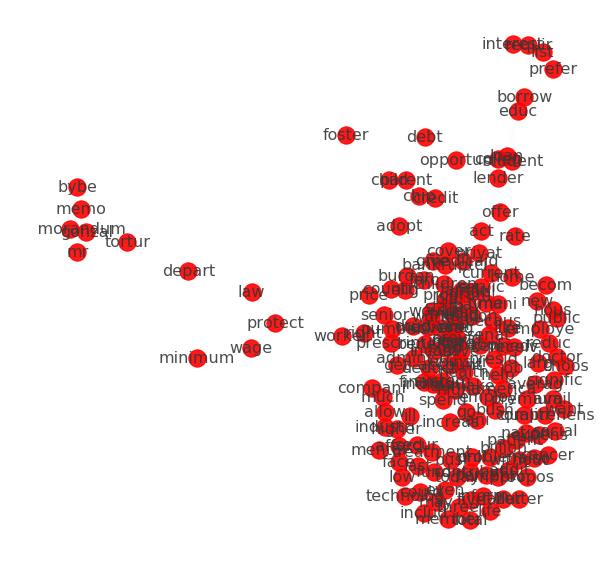

In [48]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render some reasonable networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that given insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

For this exercise I used reviews for several closed restaurants. 

In [49]:
closed_restaurant_reviews = pandas.read_csv('../Codes_Data/data/closerestaurant_reviews.csv', sep='\t')
closed_restaurant_reviews = closed_restaurant_reviews.dropna(axis=0, how='any')
closed_restaurant_reviews[:2]


business_id                                               text
0  --g-a85VwrdZJNf0R95GcQ  These guys are great. \n\nExtremely friendly a...
1  --g-a85VwrdZJNf0R95GcQ  What a wonderful surprise, this restaurant was...

In [50]:
#MYCODE
closed_restaurant_reviews['tokenized_sents'] = closed_restaurant_reviews['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
closed_restaurant_reviews['normalized_sents'] = closed_restaurant_reviews['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

In [ ]:
#MYCODE
g_review = wordCooccurrence(closed_restaurant_reviews['normalized_sents'][:100].sum())
#MYCODE
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence_review = senVectorizer.fit_transform(closed_restaurant_reviews['text'][:100])
#MYCODE
g_2mode_review = nx.Graph()

#define all the nodes
g_2mode_review.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence_review.shape[1])), bipartite = 'word')
g_2mode_review.add_nodes_from(range(senVects_incidence_review.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode_review.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence_review[d, w]}) for d, w in zip(*senVects_incidence_review.nonzero())))


In [73]:
#MYCODE
print(nx.info(g_2mode_review))

Name: 
Type: Graph
Number of nodes: 1645
Number of edges: 5038
Average degree:   6.1252


In [ ]:
#MYCODE
def contractNetwork_review(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode_review.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode_review.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [ ]:
#MYCODE
gDoc_review = contractNetwork_review(g_2mode_review, 'doc')

In [76]:
#MYCODE
print(nx.info(gDoc_review))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4636
Average degree:  92.7200


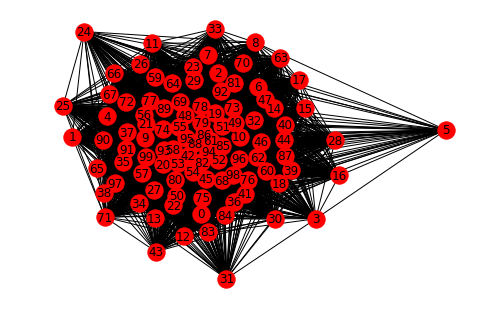

In [77]:
#MYCODE
layout_review = nx.spring_layout(gDoc_review, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc_review, pos = layout_review, labels = {n:n for n in gDoc_review.nodes()}) #Getting labels is a bit annoying

It is not surprising that every document is closely related to each other, since they are all reviews about food. Most documents gather together, excpet for document number 5.

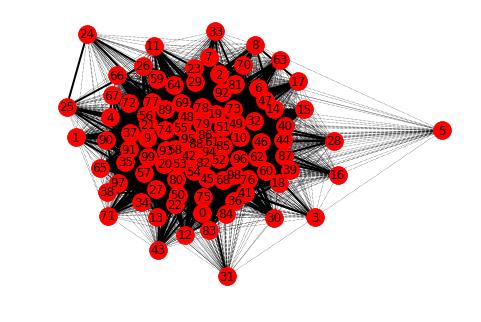

In [78]:
#MYCODE
wMedian_review = np.median([d['weight'] for n1, n2, d in gDoc_review.edges(data = True)])
edgesHigh_review = [(n1, n2) for n1, n2, d in gDoc_review.edges(data = True) if d['weight'] > wMedian_review]
edgesLow_review = [(n1, n2) for n1, n2, d in gDoc_review.edges(data = True) if d['weight'] <= wMedian_review]
nx.draw(gDoc_review, pos = layout_review, labels = {n:n for n in gDoc_review.nodes()}, edgelist = edgesLow_review, style='dotted', width=.5)
nx.draw(gDoc_review, pos = layout_review, nodelist=None, edgelist = edgesHigh_review, width=2)

Same with the conclusions from Grimmer Senate press releases corpus, the document with most words are the most central in this simple document network. Document number 5, with fewer words, is on the side.

In [79]:
#MYCODE
print(len(closed_restaurant_reviews.iloc[5]['text']),"words:","\n",closed_restaurant_reviews.iloc[5]['text'].strip().replace('  ', '\n'))

59 words: 
 super fresh food..great prices. ala carte and entrees both.


In [80]:
#MYCODE
print(len(closed_restaurant_reviews.iloc[31]['text']),"words:","\n",closed_restaurant_reviews.iloc[31]['text'].strip().replace('  ', '\n'))

263 words: 
 Another neighborhood watering hole of mine - I love that they have a mini game room and a shuffle board table.
Try the pizza and catch a game or two.. they have a ton of screens.
I also think they have quiz nights on Tuesday nights.. but don't quote me on that.


In [81]:
#MYCODE
print(len(closed_restaurant_reviews.iloc[86]['text']),"words:","\n",closed_restaurant_reviews.iloc[86]['text'].strip().replace('  ', '\n'))

2828 words: 
 It was cold for a Phoenix morning (upper 30s over-night) and I stood outside the hospital splashed in sunlight, surrounded by palm-trees and (oddly) shivering despite my wool army-drab button-down and $3 coffee. The doctor's visit went well and my spirits were high. Surgery was not an option. For now.\n\nA few minutes later, my host arrived in a green VW Rabbit. I love the new rabbits. She needed to get some work accomplished and I needed to address some email. A few (Phoenix) minutes later, we arrived at the coffee-shop. I ordered a mug of coffee and picked up a business card. Lux? That sounds familiar... Oh my goodness! LUX! I shot their first cover on top of the Smithfield at 5.30 on a Sunday morning in 2007 and the magazine was named after the coffee-shop in Phoenix where Mark and Cindy birthed the idea.\n\nThe world is tiny.\n\n---\n\n"My work is done. You wanna get breakfast?"\n\n"Do you even have to ask? What was that place you told me about before I left Philadelp

In [82]:
#MYCODE
print(len(closed_restaurant_reviews.iloc[88]['text']),"words:","\n",closed_restaurant_reviews.iloc[88]['text'].strip().replace('  ', '\n'))

2251 words: 
 Be prepared for a very very very long wait and don't come hungry. What? Don't come hungry when you're coming out to eat breakfast? Exactly! Wait time may be 2-3 hours so please do yourself a favor and snack or eat light before you come. So what tempted a Tempe girl to come out to Phoenix to eat at Matt's Big Breakfast...Triple D DUH! Haha...Diners, Drive-Ins, and Dives with Guy! He's the man! Who doesn't love him? I'm sure many people are stalking his eating stops. So cool, they have his face stenciled on the wall. \n\nOkay, so you get here and it's so teeny tiny that there's just a little stool with a waiting list. Write your name down and feel free to take off for a bit. Walk around downtown...bring board games...don't plan on just waiting outside because #1. There may not be anywhere to sit and #2. Your bottom will be very sore from sitting so long. This restaurant is in an old lobby of an old motel. You know, the old motels with the little detached lobby the size of a

Now let's look at the word-to-word network by documents.

In [83]:
#MYCODE
gWord_review = contractNetwork_review(g_2mode_review, 'word')
print(nx.info(gWord_review))

Name: 
Type: Graph
Number of nodes: 1545
Number of edges: 141605
Average degree: 183.3074


In [87]:
#MYCODE
wMean_review = np.mean([d['weight'] for n1, n2, d in gWord_review.edges(data = True)])
wMean_review

1.3325659404682038

Let's first drop all the edges with weight below 5, then drop all the isolates.

In [111]:
#MYCODE
g_review.remove_edges_from([(n1, n2) for n1, n2, d in g_review.edges(data = True) if d['weight'] <= 5])
g_review.remove_nodes_from(list(nx.isolates(g_review))) 
giant_review = max(nx.connected_component_subgraphs(g_review), key=len) 
print(nx.info(giant_review))

1545
Name: 
Type: Graph
Number of nodes: 65
Number of edges: 117
Average degree:   3.6000


If a person does not know what dataset we are using, from the visualization below he can tell for sure that it is about food, since it is in centre, with ajectives around it.

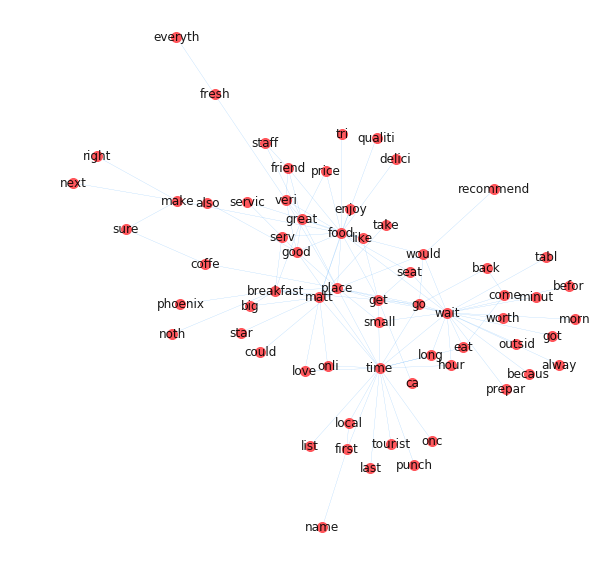

In [115]:
#MYCODE
layout_review = nx.spring_layout(giant_review, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_review, ax = ax, pos = layout_review, labels = {n:n for n in giant_review.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [117]:
#MYCODE
nx.clique.number_of_cliques(giant_review)['food']

14

In [118]:
#MYCODE
foodNeighbors = giant_review.neighbors('food')
g_food = giant_review.subgraph(foodNeighbors)
print(nx.info(g_food))

Name: 
Type: SubGraph
Number of nodes: 17
Number of edges: 36
Average degree:   4.2353


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'food'. We can see that in general the food is good, as many good adjctives, like "great","good" is around it. 

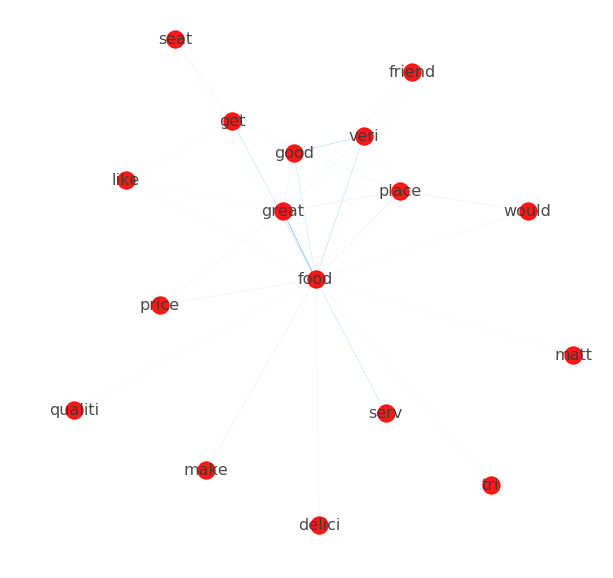

In [119]:
#MYCODE
layout_food = nx.spring_layout(g_food, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_food.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_food.edges(data = True)))
nx.draw(g_food, ax = ax, pos = layout_food, labels = {n:n for n in g_food.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_food.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [120]:
dcentralities = nx.degree_centrality(giant)

In [121]:
dcentralities['senat']

0.048484848484848485

In [122]:
max(dcentralities.items(), key = lambda x : x[1])

('health', 0.8242424242424242)

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

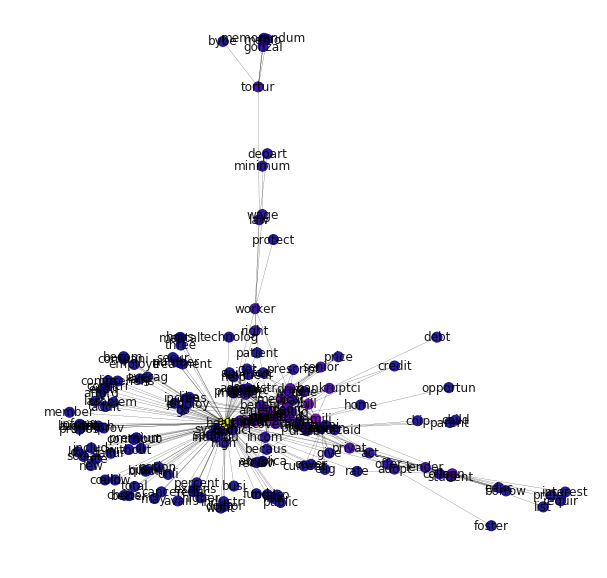

In [123]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

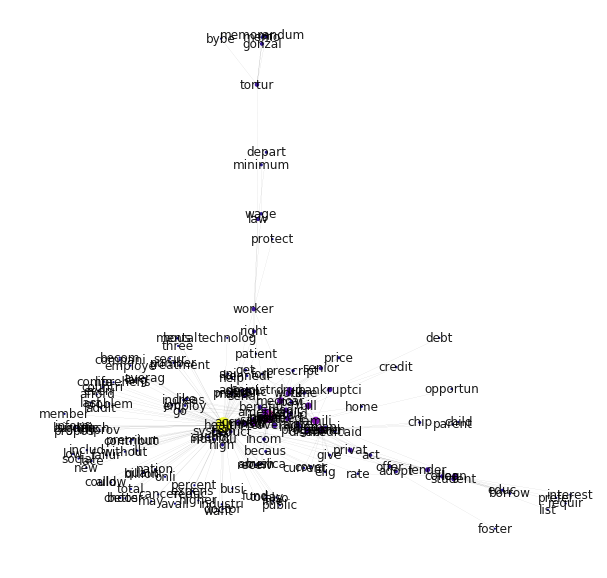

In [124]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

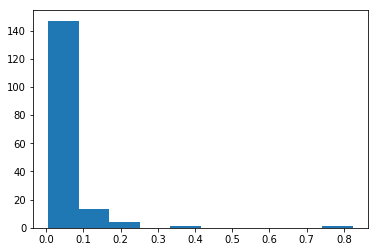

In [125]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [126]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.8242424242424242),
 ('care', 0.36363636363636365),
 ('cost', 0.23636363636363636),
 ('famili', 0.19393939393939394),
 ('children', 0.17575757575757575),
 ('year', 0.1696969696969697),
 ('plan', 0.15757575757575756),
 ('american', 0.1393939393939394),
 ('medicar', 0.1393939393939394),
 ('bill', 0.13333333333333333)]

In [127]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('new', 0.006060606060606061),
 ('total', 0.006060606060606061),
 ('nation', 0.006060606060606061),
 ('could', 0.006060606060606061),
 ('public', 0.006060606060606061),
 ('ill', 0.006060606060606061),
 ('burden', 0.006060606060606061),
 ('doctor', 0.006060606060606061),
 ('better', 0.006060606060606061),
 ('busi', 0.006060606060606061)]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [128]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [129]:
centralities['senat']

3.695491500369549e-05

In [130]:
max(centralities.items(), key = lambda x : x[1])

('health', 0.7974546258832459)

We can color and size the nodes by betweenness centrality:

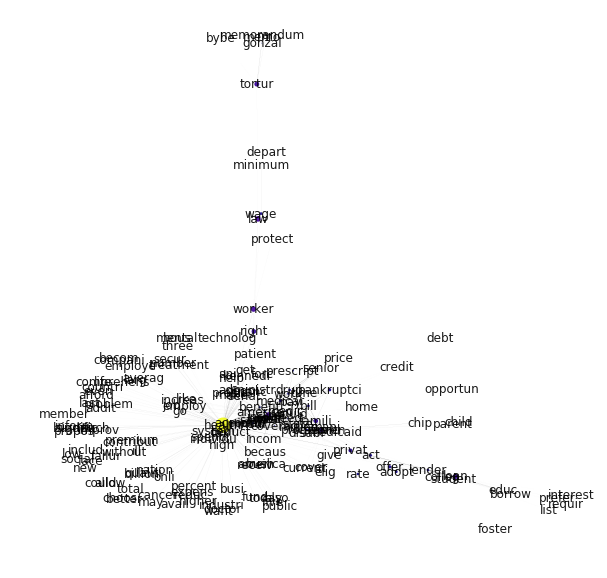

In [131]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

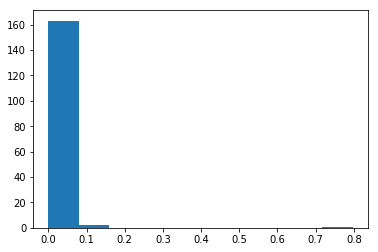

In [132]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [133]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.8242424242424242),
 ('care', 0.36363636363636365),
 ('cost', 0.23636363636363636),
 ('famili', 0.19393939393939394),
 ('children', 0.17575757575757575),
 ('year', 0.1696969696969697),
 ('plan', 0.15757575757575756),
 ('american', 0.1393939393939394),
 ('medicar', 0.1393939393939394),
 ('bill', 0.13333333333333333)]

What are words lower down?

In [134]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('prescript', 0.024242424242424242),
 ('system', 0.024242424242424242),
 ('mr', 0.024242424242424242),
 ('wage', 0.024242424242424242),
 ('high', 0.024242424242424242),
 ('servic', 0.024242424242424242),
 ('individu', 0.024242424242424242),
 ('tax', 0.024242424242424242),
 ('depart', 0.01818181818181818),
 ('minimum', 0.01818181818181818)]

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [135]:
centralities = nx.closeness_centrality(giant)

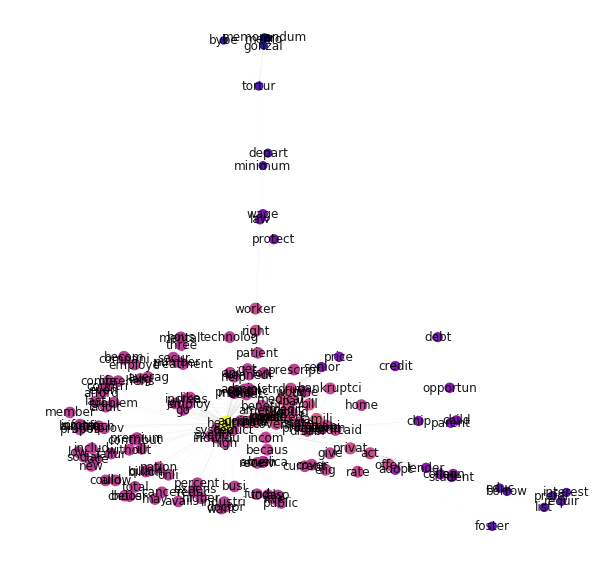

In [136]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [137]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.7638888888888888),
 ('care', 0.559322033898305),
 ('cost', 0.5092592592592593),
 ('famili', 0.5045871559633027),
 ('year', 0.4881656804733728),
 ('children', 0.4881656804733728),
 ('work', 0.4824561403508772),
 ('plan', 0.48104956268221577),
 ('bill', 0.4796511627906977),
 ('medicar', 0.4782608695652174)]

In [138]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('list', 0.26357827476038337),
 ('requir', 0.26357827476038337),
 ('tortur', 0.25152439024390244),
 ('depart', 0.24774774774774774),
 ('minimum', 0.24193548387096775),
 ('gonzal', 0.20195838433292534),
 ('memorandum', 0.20146520146520147),
 ('mr', 0.20146520146520147),
 ('memo', 0.20146520146520147),
 ('bybe', 0.20121951219512196)]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [139]:
centralities = nx.eigenvector_centrality(giant)

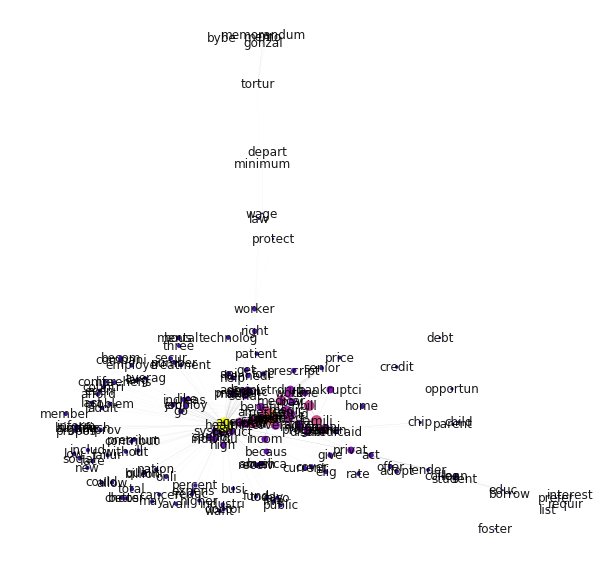

In [140]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

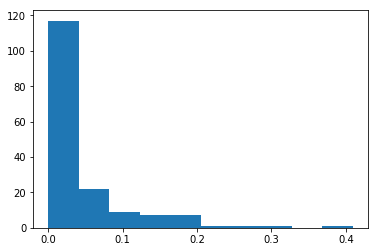

In [141]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [142]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.40940548651463987),
 ('care', 0.31410360905649315),
 ('cost', 0.2637118472565168),
 ('year', 0.22637895749862919),
 ('famili', 0.2030799342797031),
 ('plan', 0.19108150428848947),
 ('american', 0.18794543829229574),
 ('bill', 0.17714627787143086),
 ('insur', 0.17568249050178808),
 ('medicar', 0.16513397986452105)]

In [143]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('list', 0.0011729540088679337),
 ('requir', 0.0011729540088679337),
 ('tortur', 0.00022811912384458795),
 ('depart', 0.00022454856713851975),
 ('minimum', 9.79330756275329e-05),
 ('gonzal', 1.463289202381925e-05),
 ('mr', 1.331928201584216e-05),
 ('memorandum', 1.2626439035859922e-05),
 ('memo', 1.2626439035859922e-05),
 ('bybe', 1.186527016754112e-05)]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [144]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [145]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 111
Average degree:   8.8800


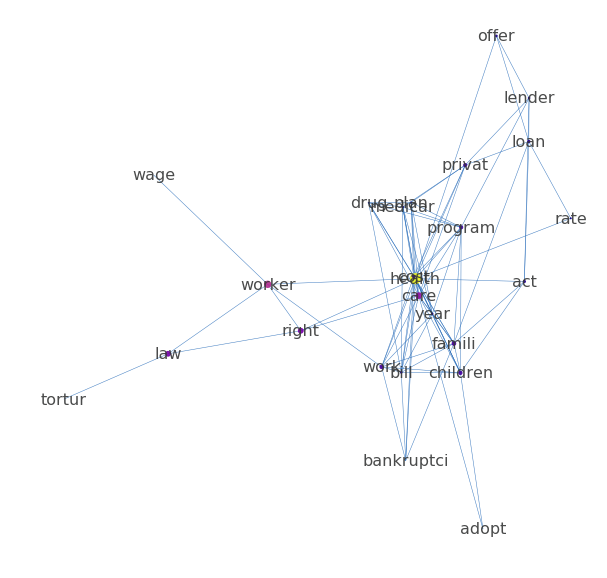

In [146]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [147]:
nx.density(giant)

0.0362175976633808

We can also calculate the average degree per node:

In [148]:
np.mean([v for w,v in nx.degree(giant)])

5.975903614457831

The diameter calculates the average distance between any two nodes in the network:

In [149]:
nx.diameter(giant)

7

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

In [150]:
dcentralities_review = nx.degree_centrality(giant_review)

First of all let's do degree centrality. We can see from the visualization, as well we from the top 10 words in terms of degree, that words, like "food","good","place" is in the center, which are good for my analysis, becuse I would like to know what people are saying about the food, or the place. From the below graph, it seems like people like these places, and the food

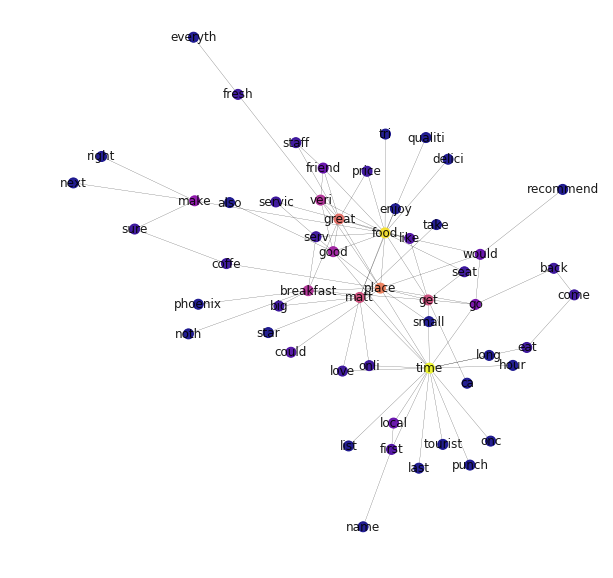

In [151]:
fig, ax = plt.subplots(figsize = (10,10))
maxC_review = max(dcentralities_review.items(), key = lambda x : x[1])[1]
nx.draw(giant_review, ax = ax, pos = layout_review, labels = {n:n for n in giant_review.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities_review[n] / maxC_review for n in giant_review.nodes],
        cmap = plt.get_cmap('plasma')) 

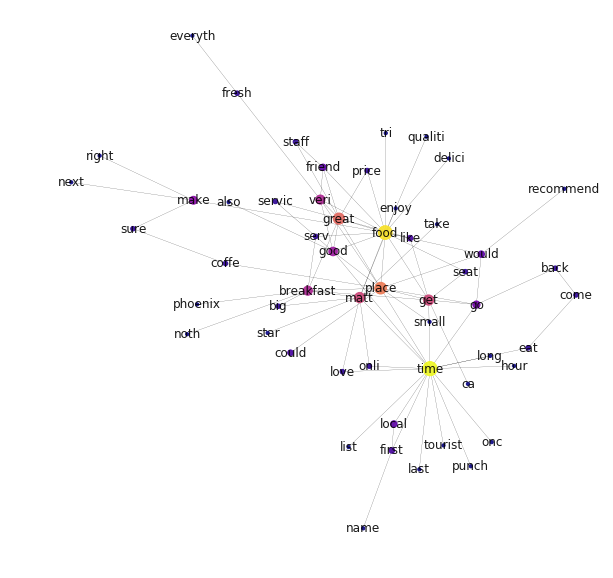

In [153]:
fig, ax = plt.subplots(figsize = (10,10))
maxC_review = max(dcentralities_review.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_review.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_review.edges(data = True)))
nx.draw(giant_review, ax = ax, pos = layout_review, labels = {n:n for n in giant_review.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord_review.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities_review[n] / maxC_review for n in giant_review.nodes],
        node_size = [dcentralities_review[n] / maxC_review * 200 for n in giant_review.nodes],
        cmap = plt.get_cmap('plasma')) 

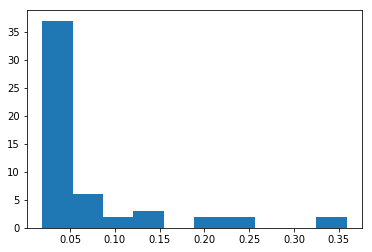

In [154]:
plt.hist(list(dcentralities_review.values()))
plt.show()

In terms of the top words, it shows that people talk a lot about the time, and the food.

In [155]:
sorted(dcentralities_review.items(), key = lambda x: x[1], reverse = True)[:10]

[('time', 0.3584905660377358),
 ('food', 0.33962264150943394),
 ('place', 0.24528301886792453),
 ('great', 0.22641509433962265),
 ('get', 0.18867924528301885),
 ('matt', 0.18867924528301885),
 ('breakfast', 0.1509433962264151),
 ('veri', 0.1509433962264151),
 ('good', 0.1320754716981132),
 ('make', 0.11320754716981132)]

In [156]:
sorted(dcentralities_review.items(), key = lambda x: x[1], reverse = True)[-10:]

[('recommend', 0.018867924528301886),
 ('also', 0.018867924528301886),
 ('noth', 0.018867924528301886),
 ('delici', 0.018867924528301886),
 ('take', 0.018867924528301886),
 ('everyth', 0.018867924528301886),
 ('onc', 0.018867924528301886),
 ('long', 0.018867924528301886),
 ('tourist', 0.018867924528301886),
 ('small', 0.018867924528301886)]

Let's look at between centrality, it is not very different from the degree centrality though.

In [157]:
betcentralities_review = nx.betweenness.betweenness_centrality(giant_review)

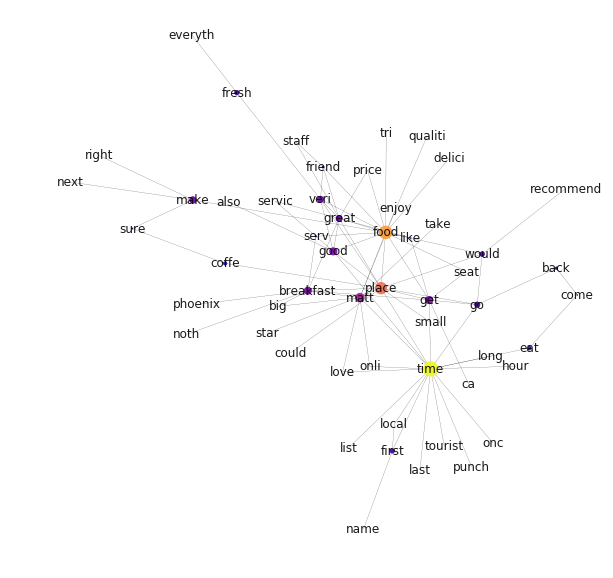

In [158]:
fig, ax = plt.subplots(figsize = (10,10))
maxC_review = max(betcentralities_review.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_review.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_review.edges(data = True)))
nx.draw(giant_review, ax = ax, pos = layout_review, labels = {n:n for n in giant_review.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord_review.edges(data = True)], 
        alpha = .9, 
        node_color = [betcentralities_review[n] / maxC_review for n in giant_review.nodes],
        node_size = [betcentralities_review[n] / maxC_review * 200 for n in giant_review.nodes],
        cmap = plt.get_cmap('plasma')) 

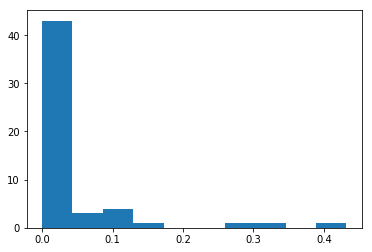

In [159]:
plt.hist(list(betcentralities_review.values()))
plt.show()

In [160]:
sorted(betcentralities_review.items(), key = lambda x: x[1], reverse = True)[:10]

[('time', 0.43185856233751735),
 ('food', 0.3337569179731733),
 ('place', 0.2771370622604294),
 ('matt', 0.15392271009107006),
 ('get', 0.1103404094695822),
 ('breakfast', 0.10730181767917617),
 ('good', 0.10727058379453154),
 ('make', 0.08901790033865505),
 ('veri', 0.07834840534405121),
 ('great', 0.07714583433015947)]

In [163]:
sorted(betcentralities_review.items(), key = lambda x: x[1], reverse = True)[-10:]

[('noth', 0.0),
 ('love', 0.0),
 ('price', 0.0),
 ('delici', 0.0),
 ('take', 0.0),
 ('everyth', 0.0),
 ('onc', 0.0),
 ('long', 0.0),
 ('tourist', 0.0),
 ('small', 0.0)]

In [164]:
clocentralities_review = nx.closeness_centrality(giant_review)

The visualization, or the top word from closeness centrality is slightly different from the other two centralities: "place" is closer to all the other individual word than "food" is, however, this does not relate much to my research.

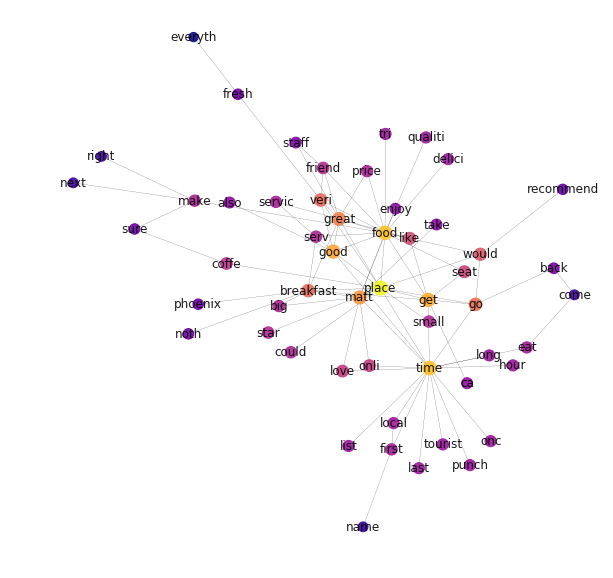

In [165]:
fig, ax = plt.subplots(figsize = (10,10))
maxC_review = max(clocentralities_review.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_review.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_review.edges(data = True)))
nx.draw(giant_review, ax = ax, pos = layout_review, labels = {n:n for n in giant_review.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord_review.edges(data = True)], 
        alpha = .9, 
        node_color = [clocentralities_review[n] / maxC_review for n in giant_review.nodes],
        node_size = [clocentralities_review[n] / maxC_review * 200 for n in giant_review.nodes],
        cmap = plt.get_cmap('plasma')) 

In [167]:
sorted(clocentralities_review.items(), key = lambda x: x[1], reverse = True)[:10]

[('place', 0.53),
 ('time', 0.49074074074074076),
 ('food', 0.49074074074074076),
 ('get', 0.4732142857142857),
 ('good', 0.4690265486725664),
 ('matt', 0.45689655172413796),
 ('great', 0.4380165289256198),
 ('go', 0.424),
 ('breakfast', 0.41732283464566927),
 ('veri', 0.41732283464566927)]

In [168]:
sorted(clocentralities_review.items(), key = lambda x: x[1], reverse = True)[-10:]

[('fresh', 0.2994350282485876),
 ('phoenix', 0.29608938547486036),
 ('noth', 0.29608938547486036),
 ('sure', 0.292817679558011),
 ('recommend', 0.28804347826086957),
 ('come', 0.25980392156862747),
 ('right', 0.25853658536585367),
 ('next', 0.25853658536585367),
 ('name', 0.2535885167464115),
 ('everyth', 0.2314410480349345)]

In [169]:
eigcentralities_review = nx.eigenvector_centrality(giant_review)

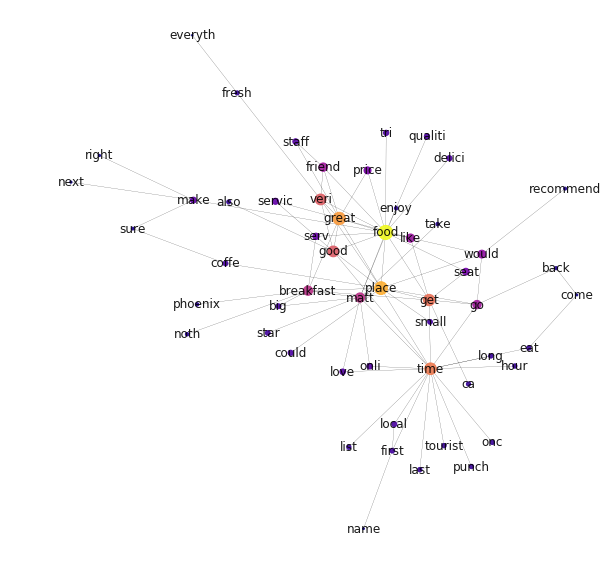

In [170]:
fig, ax = plt.subplots(figsize = (10,10))
maxC_review = max(eigcentralities_review.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_review.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_review.edges(data = True)))
nx.draw(giant_review, ax = ax, pos = layout_review, labels = {n:n for n in giant_review.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord_review.edges(data = True)], 
        alpha = .9, 
        node_color = [eigcentralities_review[n] / maxC_review for n in giant_review.nodes],
        node_size = [eigcentralities_review[n] / maxC_review * 200 for n in giant_review.nodes],
        cmap = plt.get_cmap('plasma')) 

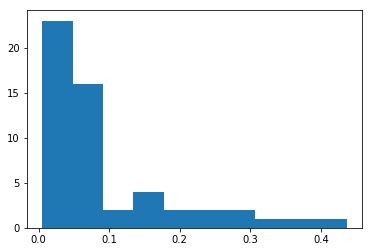

In [171]:
plt.hist(list(eigcentralities_review.values()))
plt.show()

In [172]:
sorted(eigcentralities_review.items(), key = lambda x: x[1], reverse = True)[:10]

[('food', 0.4364770092846232),
 ('place', 0.35832142272318535),
 ('great', 0.33600676443194577),
 ('time', 0.29635269059556096),
 ('get', 0.2815050942107749),
 ('veri', 0.25710836129640585),
 ('good', 0.2529792377842119),
 ('breakfast', 0.19113843044506254),
 ('matt', 0.19066642308248488),
 ('friend', 0.15416210977438216)]

In [173]:
sorted(eigcentralities_review.items(), key = lambda x: x[1], reverse = True)[-10:]

[('enjoy', 0.026761109945687287),
 ('take', 0.026761109945687287),
 ('back', 0.02286322774069541),
 ('recommend', 0.019059452271379198),
 ('sure', 0.018342851719256422),
 ('right', 0.010922850838824369),
 ('next', 0.010922850838824369),
 ('come', 0.009229033662576653),
 ('name', 0.0070938081300499535),
 ('everyth', 0.005166509089660268)]

The density of my network is not that high, meaning that there aren't that many actual connections in my network. It makes sense, since my reviews are from different restaurants, people are talking about different things.

In [174]:
nx.density(giant_review)

0.06568832983927324

The average degree per node is not that high neither, meaning that there aren't that many strong connections on average. 

In [175]:
np.mean([v for w,v in nx.degree(giant_review)])

3.4814814814814814

In [176]:
nx.diameter(giant_review)

6

# POS based networks

Now let's look at links between specific parts of speech within a network.

For this we will be using the `nltk` POS facilities instead of the Stanford ones. These are much faster, but also somewhat less accurate. (You get what you *pay* for in computational power).

Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [179]:
redditDF = pandas.read_csv('../Codes_Data/data/reddit.csv', index_col = 0)

In [180]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

author  over_18  score                subreddit  \
99  jimmy_three_shoes    False   4990  Tales From Tech Support   
98         badbfriend    False   5034            Relationships   
97             Fafrdr    False   5146            Relationships   

                                                 text  \
99  This happened a little while ago, when I was c...   
98  https://www.reddit.com/r/relationships/comment...   
97  First post: https://www.reddit.com/r/relations...   

                                                title  \
99   We've tried nothing, and we're all out of ideas!   
98  Me [29 M] with my g/f [27 F] together 4 years,...   
97  Update - My [16F] father [59M] acts creepy tow...   

                                                  url  \
99  https://www.reddit.com/r/talesfromtechsupport/...   
98  https://www.reddit.com/r/relationships/comment...   
97  https://www.reddit.com/r/relationships/comment...   

                                            sentences  
99  [[This, happened, a, little, while, ago, ,, wh...  
98  [[https, :, //www.reddit.com/r/relationships/c...  
97  [[First, post, :, https, :, //www.reddit.com/r...

Now we'll normalize the tokens through stemming:

In [181]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [182]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [183]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [184]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 2635
Number of edges: 26238
Average degree:  19.9150


This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [185]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 87
Number of edges: 1922
Average degree:  44.1839


And low weight edges:

In [186]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 87
Number of edges: 486
Average degree:  11.1724


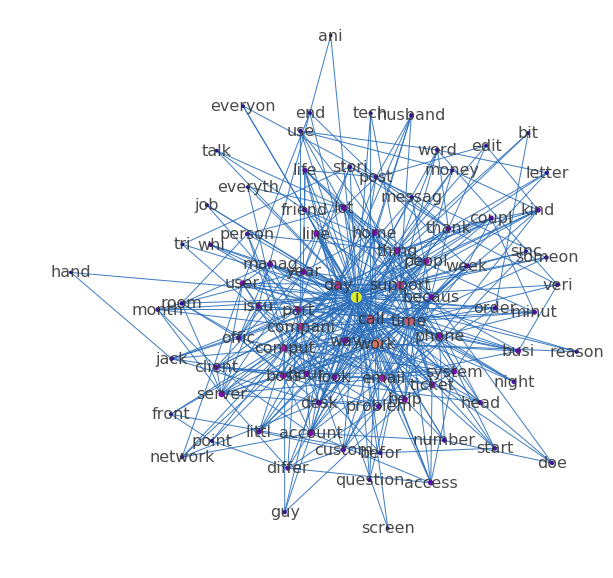

In [187]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

That is an interesting pattern; everyone is talking about themselves ("I...this", "I...that").

What if we want to look at noun-verb pairs instead?

In [188]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [189]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2871
Number of edges: 40611
Average degree:  28.2905


In [190]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [191]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2871
Number of edges: 13366
Average degree:   9.3110


Dropping low weight edges and low degree vertices gives us:

In [192]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [193]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 82
Number of edges: 450
Average degree:  10.9756


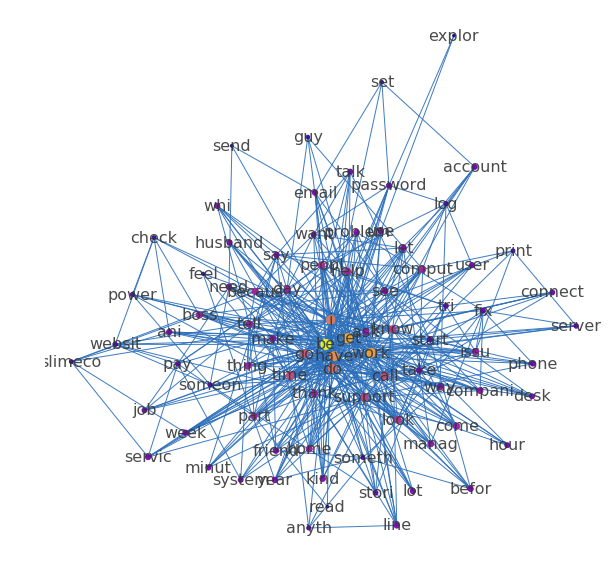

In [194]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, as we did before:

In [195]:
g_i = gNV.subgraph(['i'] + list(gNV.neighbors('i')))

In [196]:
print(nx.info(g_i))

Name: 
Type: SubGraph
Number of nodes: 34
Number of edges: 33
Average degree:   1.9412


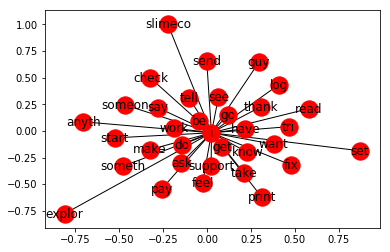

In [197]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'stori' for this:

In [198]:
storyNeighbors = gNV.neighbors('stori')
set(storyNeighbors)

{'be', 'get', 'know', 'someon', 'support', 'thank', 'tri'}

In [199]:
storyNeighbors = set(gNV.neighbors('stori'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [200]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: SubGraph
Number of nodes: 56
Number of edges: 161
Average degree:   5.7500


This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

In [201]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.8727272727272727),
 ('get', 0.7090909090909091),
 ('support', 0.39999999999999997),
 ('know', 0.36363636363636365),
 ('thank', 0.3090909090909091),
 ('tri', 0.14545454545454545),
 ('someon', 0.12727272727272726),
 ('call', 0.12727272727272726),
 ('stori', 0.12727272727272726),
 ('i', 0.12727272727272726)]

Or eigenvector centrality:

In [202]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.4392898420289854),
 ('get', 0.3826631410829017),
 ('support', 0.24421847103891123),
 ('know', 0.21111457825779467),
 ('thank', 0.19442994690119705),
 ('call', 0.15627933587529896),
 ('stori', 0.15627933587529896),
 ('i', 0.15627933587529896),
 ('issu', 0.14825532139380798),
 ('help', 0.14825532139380798)]

Notice that 'stori' isn't even in the top 5:

Lets plot it:

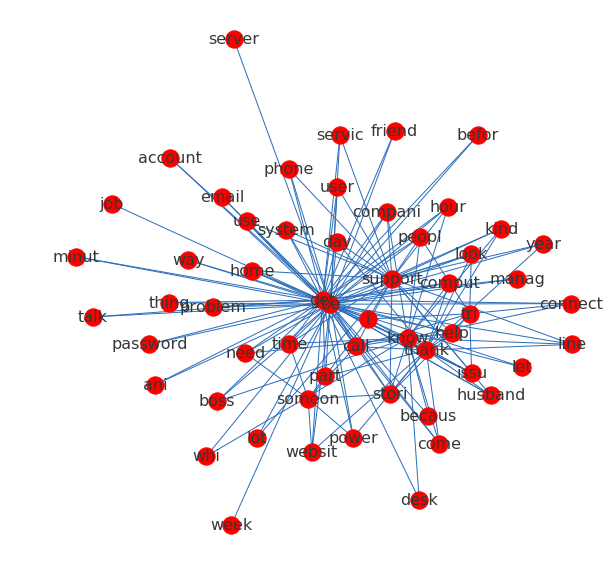

In [203]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

"I" is still in the middle. These are stories about the self.

Lets create a noun-adjective network:

In [204]:
gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 3114
Number of edges: 42799
Average degree:  27.4881


By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

In [205]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 74
Average degree:   5.9200


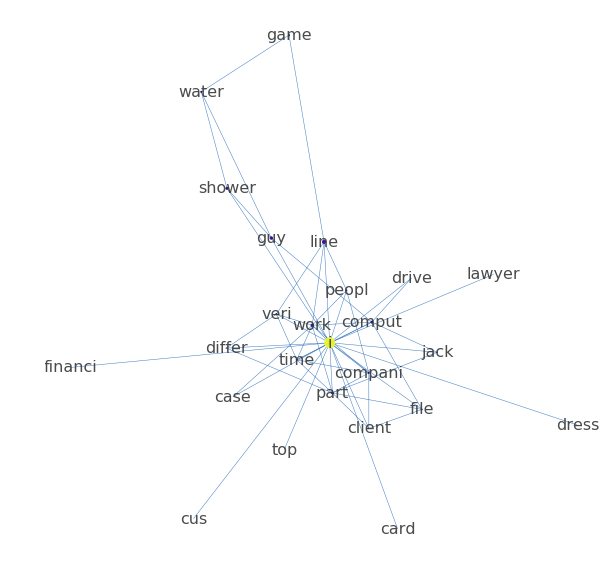

In [206]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

A truly self-centered network.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

For this exercise I chose reviews from the first close restuarnt to analyze. 

In [214]:
first_closed_restaurant = closed_restaurant_reviews[closed_restaurant_reviews['business_id']=='--g-a85VwrdZJNf0R95GcQ']
first_closed_restaurant

business_id                                               text  \
0   --g-a85VwrdZJNf0R95GcQ  These guys are great. \n\nExtremely friendly a...   
1   --g-a85VwrdZJNf0R95GcQ  What a wonderful surprise, this restaurant was...   
2   --g-a85VwrdZJNf0R95GcQ  Ordered takeout from the place and the food wa...   
3   --g-a85VwrdZJNf0R95GcQ  fantastic to have a true Mediterranean restaur...   
4   --g-a85VwrdZJNf0R95GcQ  All the food is very fresh and incredibly deli...   
5   --g-a85VwrdZJNf0R95GcQ  super fresh food..great prices. ala carte and ...   
6   --g-a85VwrdZJNf0R95GcQ  Great Food! Good Service! Very friendly family...   
7   --g-a85VwrdZJNf0R95GcQ  This probably one of the better Middle Eastern...   
8   --g-a85VwrdZJNf0R95GcQ  My new favorite Mediterranean food restaurant!...   
9   --g-a85VwrdZJNf0R95GcQ  I saw a sign for this place on our way to the ...   
10  --g-a85VwrdZJNf0R95GcQ  Very Cool Mom and Pop restaurant serving some ...   
11  --g-a85VwrdZJNf0R95GcQ  Delicious. The salad is outstanding. The kebob...   
12  --g-a85VwrdZJNf0R95GcQ  Love this place! Great tabouleh, falafel and k...   
13  --g-a85VwrdZJNf0R95GcQ  This place is FANTASTIC! Very generous portion...   
14  --g-a85VwrdZJNf0R95GcQ  Our new favorite resturant for a weekday date ...   
15  --g-a85VwrdZJNf0R95GcQ  This place is AMAZING and DELICIOUS!!!! The fo...   
16  --g-a85VwrdZJNf0R95GcQ  Unhappy about the hours. Change the yelp ad. Y...   
17  --g-a85VwrdZJNf0R95GcQ  The service was great and the variety on menu ...   
18  --g-a85VwrdZJNf0R95GcQ  I was in the Kabab House for the first time on...   
19  --g-a85VwrdZJNf0R95GcQ  I am always SUPER excited when an authentic et...   
20  --g-a85VwrdZJNf0R95GcQ  The best Middle Eastern food I've had in Phoen...   
21  --g-a85VwrdZJNf0R95GcQ  So I was super excited when a new middle easte...   
22  --g-a85VwrdZJNf0R95GcQ  My Daughter, grandsons and I were looking for ...   
23  --g-a85VwrdZJNf0R95GcQ  Great food, and great prices.  The family and ...   

                                      tokenized_sents  \
0   [[These, guys, are, great, .], [\n\nExtremely,...   
1   [[What, a, wonderful, surprise, ,, this, resta...   
2   [[Ordered, takeout, from, the, place, and, the...   
3   [[fantastic, to, have, a, true, Mediterranean,...   
4   [[All, the, food, is, very, fresh, and, incred...   
5   [[super, fresh, food..great, prices, .], [ala,...   
6   [[Great, Food, !], [Good, Service, !], [Very, ...   
7   [[This, probably, one, of, the, better, Middle...   
8   [[My, new, favorite, Mediterranean, food, rest...   
9   [[I, saw, a, sign, for, this, place, on, our, ...   
10  [[Very, Cool, Mom, and, Pop, restaurant, servi...   
11  [[Delicious, .], [The, salad, is, outstanding,...   
12  [[Love, this, place, !], [Great, tabouleh, ,, ...   
13  [[This, place, is, FANTASTIC, !], [Very, gener...   
14  [[Our, new, favorite, resturant, for, a, weekd...   
15  [[This, place, is, AMAZING, and, DELICIOUS, !,...   
16  [[Unhappy, about, the, hours, .], [Change, the...   
17  [[The, service, was, great, and, the, variety,...   
18  [[I, was, in, the, Kabab, House, for, the, fir...   
19  [[I, am, always, SUPER, excited, when, an, aut...   
20  [[The, best, Middle, Eastern, food, I, 've, ha...   
21  [[So, I, was, super, excited, when, a, new, mi...   
22  [[My, Daughter, ,, grandsons, and, I, were, lo...   
23  [[Great, food, ,, and, great, prices, .], [The...   

                                     normalized_sents  
0   [[guy, great], [friend, nice, servic], [food, ...  
1   [[wonder, surpris, restaur], [famili, restaur,...  
2   [[order, takeout, place, food, great], [got, g...  
3   [[fantast, true, mediterranean, restaur, every...  
4   [[food, veri, fresh, incred, delici], [falafel...  
5         [[super, fresh, price], [ala, cart, entre]]  
6   [[great, food], [good, servic], [veri, friend,...  
7   [[probabl, one, better, middl, eastern, restau...  
8   [[new, favorit, mediterranean, food, restaur],...  
9  

In [241]:
gNN_review = posCooccurrence(first_closed_restaurant['normalized_sents'].sum(), 'NN')

In [235]:
print(nx.info(gNN_review))

Name: 
Type: Graph
Number of nodes: 271
Number of edges: 1161
Average degree:   8.5683


In [243]:
gNN_review.remove_edges_from([(n1, n2) for n1, n2, d in gNN_review.edges(data = True) if d['weight'] <= 1])
print(nx.info(gNN_review))

Name: 
Type: Graph
Number of nodes: 252
Number of edges: 128
Average degree:   1.0159


In [245]:
gNN_review.remove_nodes_from([n for n in gNN_review.nodes if len(set(gNN_review.neighbors(n))) <= 1]) 
print(nx.info(gNN_review))

Name: 
Type: Graph
Number of nodes: 38
Number of edges: 89
Average degree:   4.6842


Let's first look at nouns co-occurring in sentences. I think this graph is quite interesting in that you can actually tell that this restaurant is very likely to be a Middle Eastern food restaurant, because everyone is talking about "pita", "falafel". Kafta is a type of beef kabab(haha I checked!).

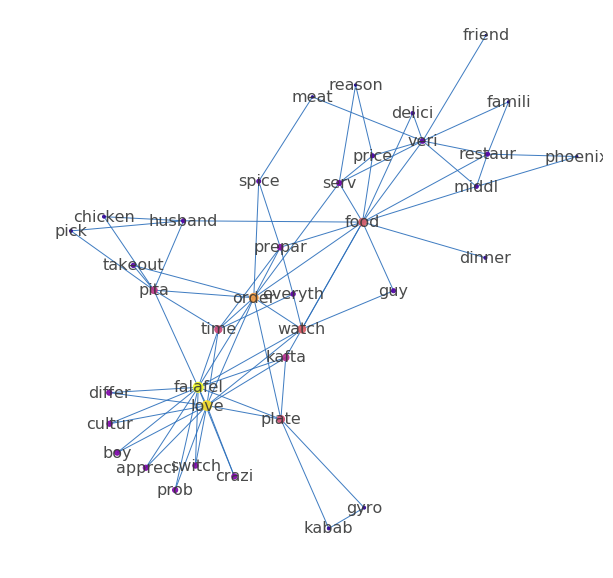

In [246]:
layout_nn_review = nx.spring_layout(gNN_review, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn_review = nx.eigenvector_centrality(gNN_review)
maxC = max(centralities_nn_review.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN_review.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN_review.edges(data = True)))
nx.draw(gNN_review, ax = ax, pos = layout_nn_review, labels = {n: n for n in gNN_review.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn_review[n] / maxC for n in gNN_review.nodes],
        node_size = [centralities_nn_review[n] / maxC * 100 for n in gNN_review.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

Now let's see what people are actually saying about these food.

In [247]:
gNJ_review = posCooccurrence(first_closed_restaurant['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ_review))

Name: 
Type: Graph
Number of nodes: 350
Number of edges: 2120
Average degree:  12.1143


In [249]:
gNJ_review.remove_nodes_from([n for n in gNJ_review.nodes if len(set(gNJ_review.neighbors(n))) <= 1]) 
print(nx.info(gNJ_review))

Name: 
Type: Graph
Number of nodes: 336
Number of edges: 2110
Average degree:  12.5595


In [250]:
gNJ_review.remove_edges_from([(n1, n2) for n1, n2, d in gNJ_review.edges(data = True) if d['weight'] <= 1])
print(nx.info(gNJ_review))

Name: 
Type: Graph
Number of nodes: 336
Number of edges: 259
Average degree:   1.5417


In [252]:
gNJ_review.remove_nodes_from([n for n in gNJ_review.nodes if len(set(gNJ_review.neighbors(n))) <= 1]) 
print(nx.info(gNJ_review))

Name: 
Type: Graph
Number of nodes: 73
Number of edges: 193
Average degree:   5.2877


From the graph below we can see that ingeneral people love the food here, especially the falafel, but maybe not so much about the pita, as "disappoint" is related to the  pita. I can also tell for sure now that it is middle eastern cuisine, as it shows up in the graph below. I think this method can really help me in my following research on seeing what people are saying about different aspects of the restaurants.

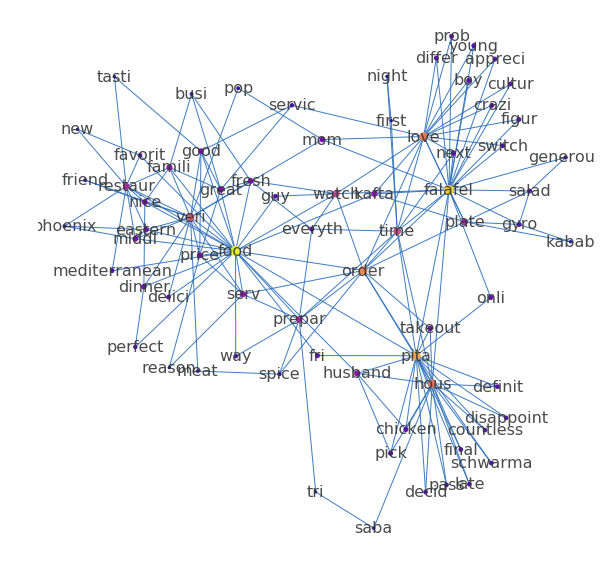

In [253]:
layout_nj_review = nx.spring_layout(gNJ_review, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj_review = nx.eigenvector_centrality(gNJ_review)
maxC = max(centralities_nn_review.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNJ_review.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNJ_review.edges(data = True)))
nx.draw(gNJ_review, ax = ax, pos = layout_nj_review, labels = {n: n for n in gNJ_review.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nj_review[n] / maxC for n in gNJ_review.nodes],
        node_size = [centralities_nj_review[n] / maxC * 100 for n in gNJ_review.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [262]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [269]:
result_path = '../Codes_Data/data/Bayesian-echo/{}/'.format(example_name)

In [270]:
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [271]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Foreman': 3,
 'Juror 10': 2,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 2': 9,
 'Juror 3': 1,
 'Juror 4': 5,
 'Juror 5': 11,
 'Juror 6': 8,
 'Juror 7': 4,
 'Juror 8': 0,
 'Juror 9': 10}

In [312]:
df_influence

influence.1.1  influence.1.2  influence.1.3  influence.1.4  \
0               0.0       7.240730       4.702604   2.539944e-03   
1               0.0       3.103347       5.093965   5.242095e-03   
2               0.0       3.361763       4.313076   7.637620e-03   
3               0.0       6.789371       9.210530   1.229763e-02   
4               0.0       6.204194       6.458375   6.054170e-03   
5               0.0       2.755310       7.683268   3.242710e-03   
6               0.0       5.075882       7.450617   5.228197e-01   
7               0.0       4.899820       4.649069   4.643661e-01   
8               0.0       5.222009       9.442162   2.388935e+00   
9               0.0       3.511327       9.968112   2.508117e+00   
10              0.0       3.775137       8.961138   2.369973e+00   
11              0.0       5.140072       5.778375   2.892303e-01   
12              0.0       4.824758       7.319805   2.817950e-01   
13              0.0       5.755132       8.583065   9.026183e-01   
14              0.0       6.836798       6.946363   8.150652e-01   
15              0.0       4.764239       8.077001   2.465762e+00   
16              0.0       4.880874       8.714443   2.721373e+00   
17              0.0       5.035513       8.591366   1.555206e+00   
18              0.0       5.398599       8.023368   6.747021e-01   
19              0.0       6.692010       7.355668   1.444345e+00   
20              0.0       6.634487       2.659674   1.219165e+00   
21              0.0       5.879594       2.792392   2.498230e-01   
22              0.0       7.827487       2.824069   7.145174e-01   
23              0.0       4.235644       6.506925   6.412022e-01   
24              0.0       4.569337       9.920599   7.676732e-02   
25              0.0       4.910078       9.744725   4.175752e-01   
26              0.0       5.613525       7.975647   9.184212e-01   
27              0.0       5.097952       8.546807   8.299517e-01   
28              0.0       6.139725       9.164903   8.368242e-01   
29              0.0       8.031317       7.528605   4.658336e+00   
...             ...            ...            ...            ...   
1970            0.0       2.882116       8.617505   5.627020e+00   
1971            0.0       6.575012       9.490077   4.523977e+00   
1972            0.0       3.533977       5.352980   4.044499e+00   
1973            0.0       4.888824       8.360121   2.583465e-02   
1974            0.0       6.010576       8.070197   3.380549e-02   
1975            0.0       5.359240       9.251879   2.304495e-02   
1976            0.0       6.303236       7.868448   1.752933e-02   
1977            0.0       2.486314       8.856175   2.514236e-02   
1978            0.0       2.967166       5.656860   1.134738e-02   
1979            0.0       3.458320       4.963233   6.248215e-03   
1980            0.0       1.868924       4.495827   1.444701e-02   
1981            0.0       0.250287       4.569778   1.976374e-03   
1982            0.0       5.342089       3.253657   1.201103e-04   
1983            0.0       4.522946       2.957481   6.530617e-05   
1984            0.0       0.965922       6.672158   9.935493e-06   
1985            0.0       4.931199       8.668433   2.586494e-06   
1986            0.0       1.831687       8.891186   4.938042e-06   
1987            0.0       1.763503       8.436452   1.110028e-05   
1988            0.0       0.493434       8.939641   8.912776e-06   
1989            0.0       0.221250       7.144330   1.979707e-06   
1990            0.0       1.276648       8.357043   4.355422e-07   
1991            0.0       2.937864       8.697922   1.992275e-08   
1992            0.0       2.324730       4.884105   1.244916e-08   
1993            0.0       1.594385       7.224367   7.827687e-09   
1994            0.0       2.413303       9.507713   5.400076e-09   
1995            0.0       7.586467       9.074625   4.316770e-09   
1996            0.0       0.334525       9.091988   2.113915e-

In [272]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

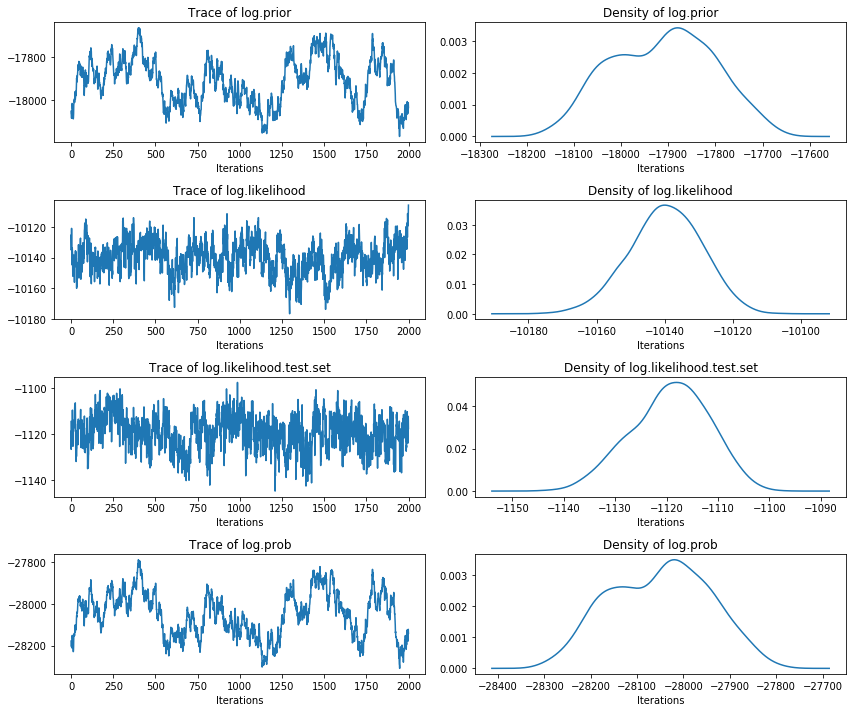

In [273]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [274]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [275]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [276]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [277]:
df_mean

Juror 8   Juror 3  Juror 10   Foreman   Juror 7   Juror 4  \
Juror 8   0.000000  3.757957  8.089079  0.930180  5.167497  0.794645   
Juror 3   8.529312  0.000000  6.673916  4.150076  2.534751  4.902852   
Juror 10  8.413188  7.427932  0.000000  4.540236  3.216307  1.030049   
Foreman   1.137060  0.612615  1.945196  0.000000  1.521390  0.834870   
Juror 7   2.603853  5.901169  0.648844  1.969868  0.000000  1.110101   
Juror 4   5.791320  0.200669  0.266484  0.582956  0.094200  0.000000   
Juror 11  0.378515  0.544628  0.779340  0.454645  0.290575  0.447512   
Juror 12  5.961338  0.695831  0.519459  1.253033  0.247939  0.162463   
Juror 6   4.526244  0.923784  0.503503  1.049825  1.288920  0.451562   
Juror 2   0.583732  2.303417  0.529583  1.722894  2.005939  0.299311   
Juror 9   1.216641  1.281288  0.967587  1.675483  1.657341  1.681338   
Juror 5   0.552951  1.001575  0.696393  1.180245  1.180355  0.497265   

          Juror 11  Juror 12   Juror 6   Juror 2   Juror 9   Juror 5  
Juror 8   0.845335  1.336329  6.106684  0.916765  6.385205  7.300776  
Juror 3   1.092571  0.509942  3.825015  3.861767  0.266426  1.561626  
Juror 10  1.004598  0.529232  2.426582  0.407460  1.233599  0.885871  
Foreman   1.338554  3.230634  1.013511  3.534036  1.311436  4.115411  
Juror 7   0.279870  0.608548  1.047693  2.910670  1.619475  1.570038  
Juror 4   3.347982  0.316963  0.300770  2.112033  0.370973  0.673364  
Juror 11  0.000000  0.614536  0.821143  0.951222  0.476986  0.844157  
Juror 12  0.388620  0.000000  2.500976  2.375977  0.481394  0.834032  
Juror 6   0.375776  0.904313  0.000000  2.861587  0.905421  0.310822  
Juror 2   0.652302  1.623813  0.841376  0.000000  1.691612  1.756225  
Juror 9   0.623032  1.925996  1.907992  0.539666  0.000000  1.138934  
Juror 5   0.786181  0.588822  0.724613  0.912616  1.224854  0.000000

MEAN of influence matrix (row=from, col=to)


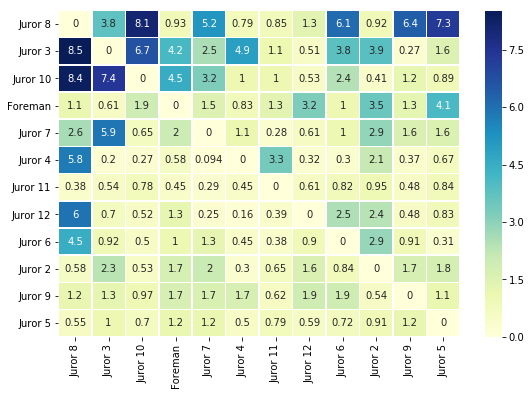

In [278]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


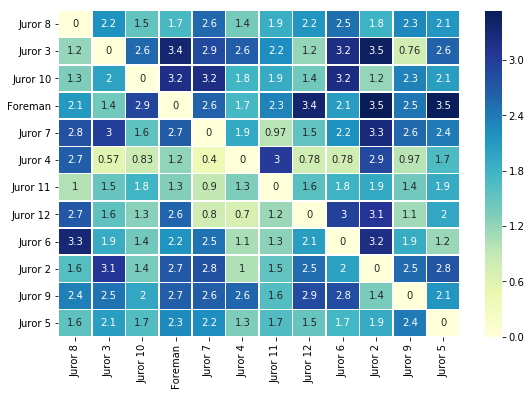

In [279]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [280]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


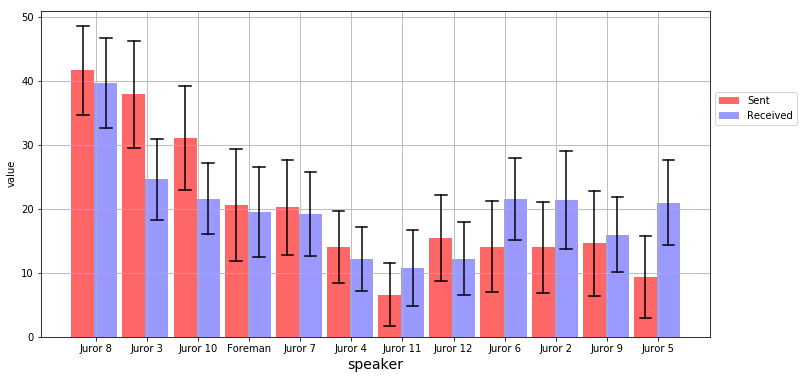

In [281]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [282]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [283]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


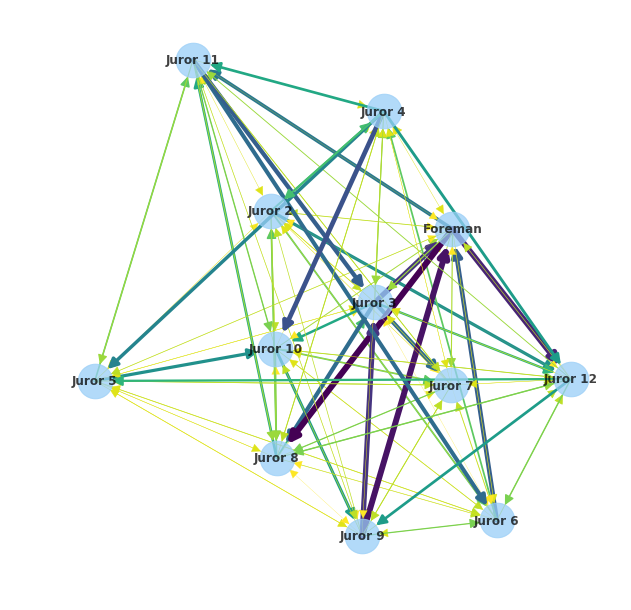

In [284]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


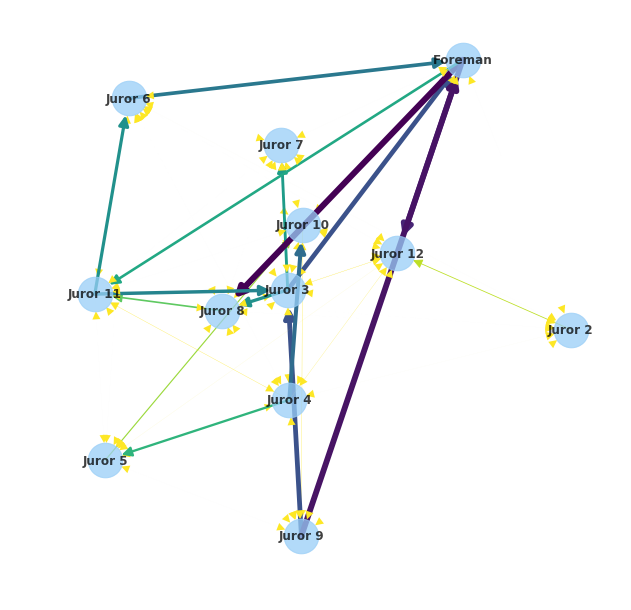

In [285]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


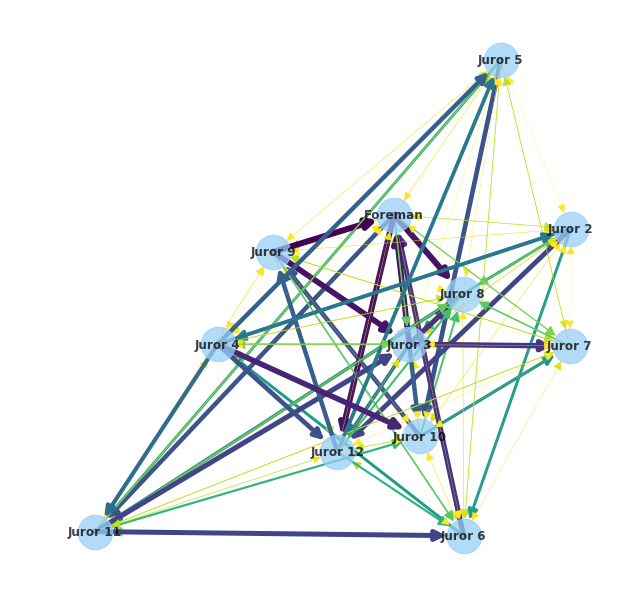

In [286]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [287]:
import lucem_illud
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [291]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

name                                             tokens     start  \
0  Nixon  [gjls, jdsh, iffh, chkh, ibcs, fdll, jfce, ddg...  0.972145   
1   Ford  [ehll, gakg, jhcs, jceb, cclk, cagj, fess, llf...  2.611468   

        end  
0  1.290822  
1  3.144891

Transform data into TalkbankXML format:

In [347]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/USpresident/USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [356]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

Realtime output can be viewed in shell.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that either (1) take data from a transcribed conversation, online chat forum, comment chain or some other *timed* interaction and calculate Bayesian influence; or (2) build a simulation similar in spirit to the "Presidents" example above, ideally infusing it with interesting "stylized facts". What does that estimation and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

For this exercise I downloaded this corpus that contains a collection of conversations from the U.S. Supreme Court Oral Arguments with

- 51,498 utterances making up 50,389 conversational exchanges
- from 204 cases involving 11 Justices and 311 other participants (lawyers or amici curiae)


In [368]:
col_names=['case_id','utterance_id','after_previous','name','is_justice','justice_vote','presentation_side','utterance']
df_conversations = pandas.read_csv('../data_original/supreme_conversations.txt',sep='\++\$\++',header=None,names=col_names)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [369]:
df_conversations = df_conversations.drop(['case_id','utterance_id','after_previous','is_justice','justice_vote','presentation_side'], axis=1)


In [370]:
df_conversations.shape

(51498, 2)

In [371]:
for index,row in df_conversations.iterrows():
    df_conversations.set_value(index,'start',np.random.random())
    df_conversations.set_value(index,'end',1+np.random.random())


In [372]:
df_conversations['tokens'] = df_conversations['utterance'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
df_conversations[:5]

name                                          utterance  \
0    JUSTICE STEVENS    We will now hear argument in the Cherokee Nat...   
1         MR. MILLER    Justice Stevens, and may it please the Court:...   
2   JUSTICE O'CONNOR    Would you mind explaining to us how these two...   
3         MR. MILLER    No, Justice O'Connor. They're -- they're not ...   
4   JUSTICE O'CONNOR    But they're certainly at odds on the legal th...   

      start       end                                             tokens  
0  0.173237  1.327076  [[We, will, now, hear, argument, in, the, Cher...  
1  0.011490  1.557833  [[Justice, Stevens, ,, and, may, it, please, t...  
2  0.415596  1.536761  [[Would, you, mind, explaining, to, us, how, t...  
3  0.109153  1.457619  [[No, ,, Justice, O'Connor, .], [They, 're, --...  
4  0.761626  1.928526  [[But, they, 're, certainly, at, odds, on, the...

In [403]:
df_conversations_small = df_conversations[:300]

In [404]:
output_fname_conversation = 'USsupreme.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_conversations_small, output_fname_conversation, language = language )

//anaconda/lib/python3.5/site-packages/lucem_illud/bayesian.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['start'] = df['start'].apply(pd.to_numeric)


New File saved to ./data/USsupreme/USsupreme.xml


//anaconda/lib/python3.5/site-packages/lucem_illud/bayesian.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['end'] = df['end'].apply(pd.to_numeric)


0

In [405]:
Vocab_size = 50 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname_conversation, Vocab_size, language, sampling_time)

AFter 2 hours... I finally had the result!

In [406]:
df_influence_supreme = pandas.read_csv('../Codes_Data/results/USsupreme/SAMPLE-influence.txt',delim_whitespace=True) # influence samples


In [408]:
df_participants_supreme = pandas.read_csv('../Codes_Data/results/USsupreme/cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants_supreme['agent.num'].values-1,index=df_participants_supreme['agent.name']).to_dict()


In [409]:
A = int(np.sqrt(len(df_influence_supreme.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [410]:
stacked = df_influence_supreme.mean(axis=0)
df_mean_supreme = getmatrix(stacked,A)

stacked = df_influence_supreme.std(axis=0)
df_std_supreme = getmatrix(stacked,A)

MEAN of influence matrix (row=from, col=to)


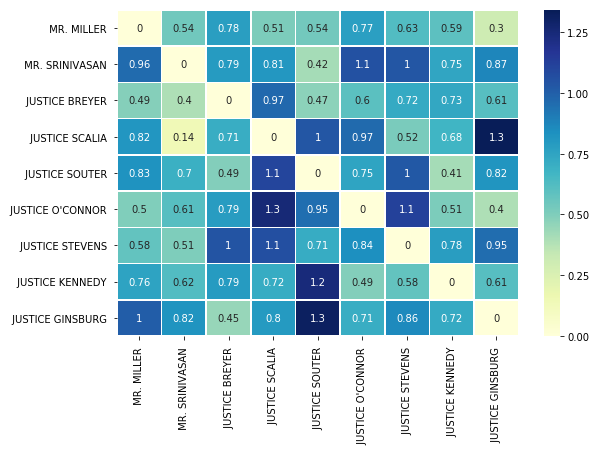

In [411]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean_supreme, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


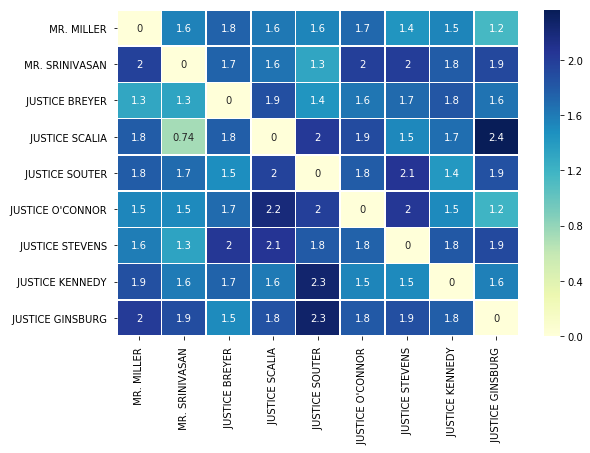

In [412]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std_supreme, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

In [413]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence_supreme[df_influence_supreme.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence_supreme[df_influence_supreme.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent_supreme = df_mean_supreme.sum(axis=1) #mean of total influence sent
recieved_supreme =df_mean_supreme.sum(axis=0) #mean of total influence recieved

		Total linguistic influence sent/received 


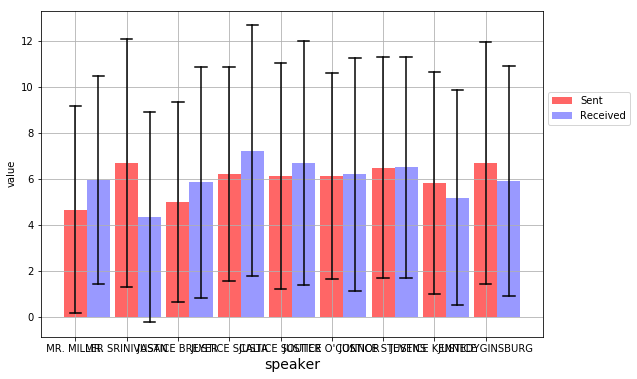

In [433]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,30]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent_supreme.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent_supreme.loc[p]+sender_std[p],sent_supreme.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent_supreme.loc[p]-sender_std[p],sent_supreme.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent_supreme.loc[p]-sender_std[p],sent_supreme.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved_supreme.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved_supreme.loc[p]+reciever_std[p],recieved_supreme.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved_supreme.loc[p]-reciever_std[p],recieved_supreme.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved_supreme.loc[p]-reciever_std[p],recieved_supreme.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

In [419]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence_supreme.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence_supreme.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence_supreme.quantile(0.75)
df_q75 = getmatrix(stacked,A)

I think this graph is quite interesting in that we can see vividly how people are influencing each other through conversations between these people. For example we can see from the graph that Justice Kennedy is influenced by Mr.Miller. So I go back to the outcome of the winning side for this case, it indicates that in this case, the PETITIONER, represented in the example by Mr. Miller won the case. So it agrees with the actual outcome:)


Mean Influence Network


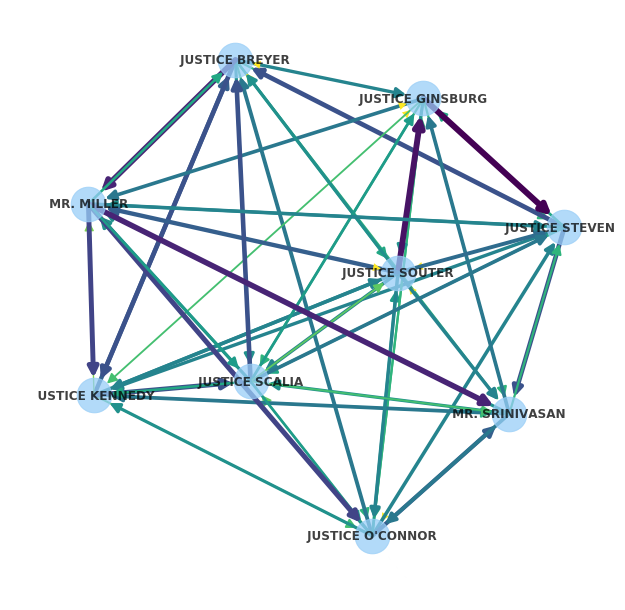

In [420]:
G_mean = drawNetwork(df_mean_supreme,'Mean Influence Network')

25 Quantile Influence Network


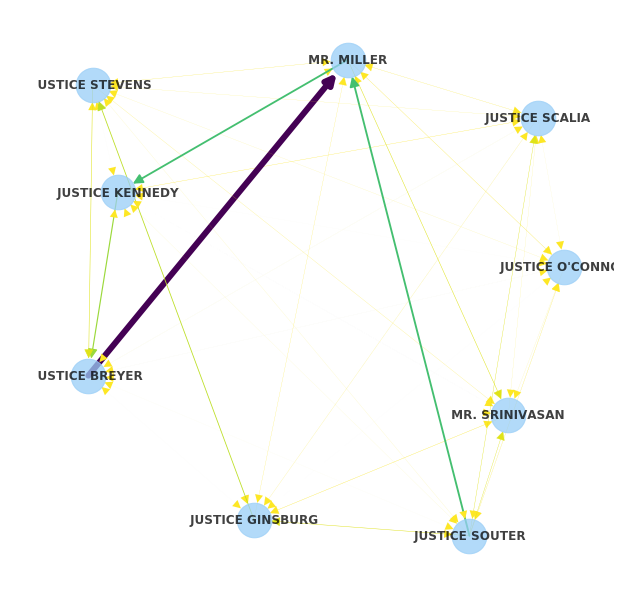

In [421]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


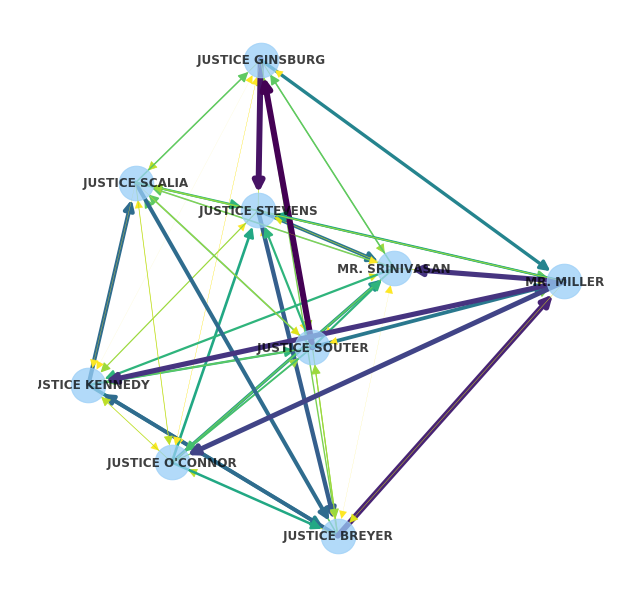

In [422]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')